In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'Bayes-ML-sld')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'Bayes-ML-sld', 'src')
sys.path.append(src_dir)


In [21]:
import reflectivity_model

config_file = os.path.join(git_dir, 'scripts', 'config-cell-b.json')
with open(config_file, 'r') as fd:
    config = json.load(fd)


m = reflectivity_model.ReflectivityModels(q=None, name=config['name'],
                                          max_thickness=config['max_thick'],
                                          dz=config['dz'],
                                          fix_first_n=config['fix_first_n'])

m.model_description = config['model']
m.parameters = config['parameters']


OSError: /Users/m2d/git/Bayes-ML-sld/data/REFL_201282_reduced_data.txt not found.

In [14]:
import rl_model
importlib.reload(rl_model)

# create an instance of our custom environment
env = rl_model.SLDEnv(m)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

0
[  6.8032646   6.247122  175.36073    10.689959    4.7179494  23.932152
  23.720541 ]


<IPython.core.display.Javascript object>


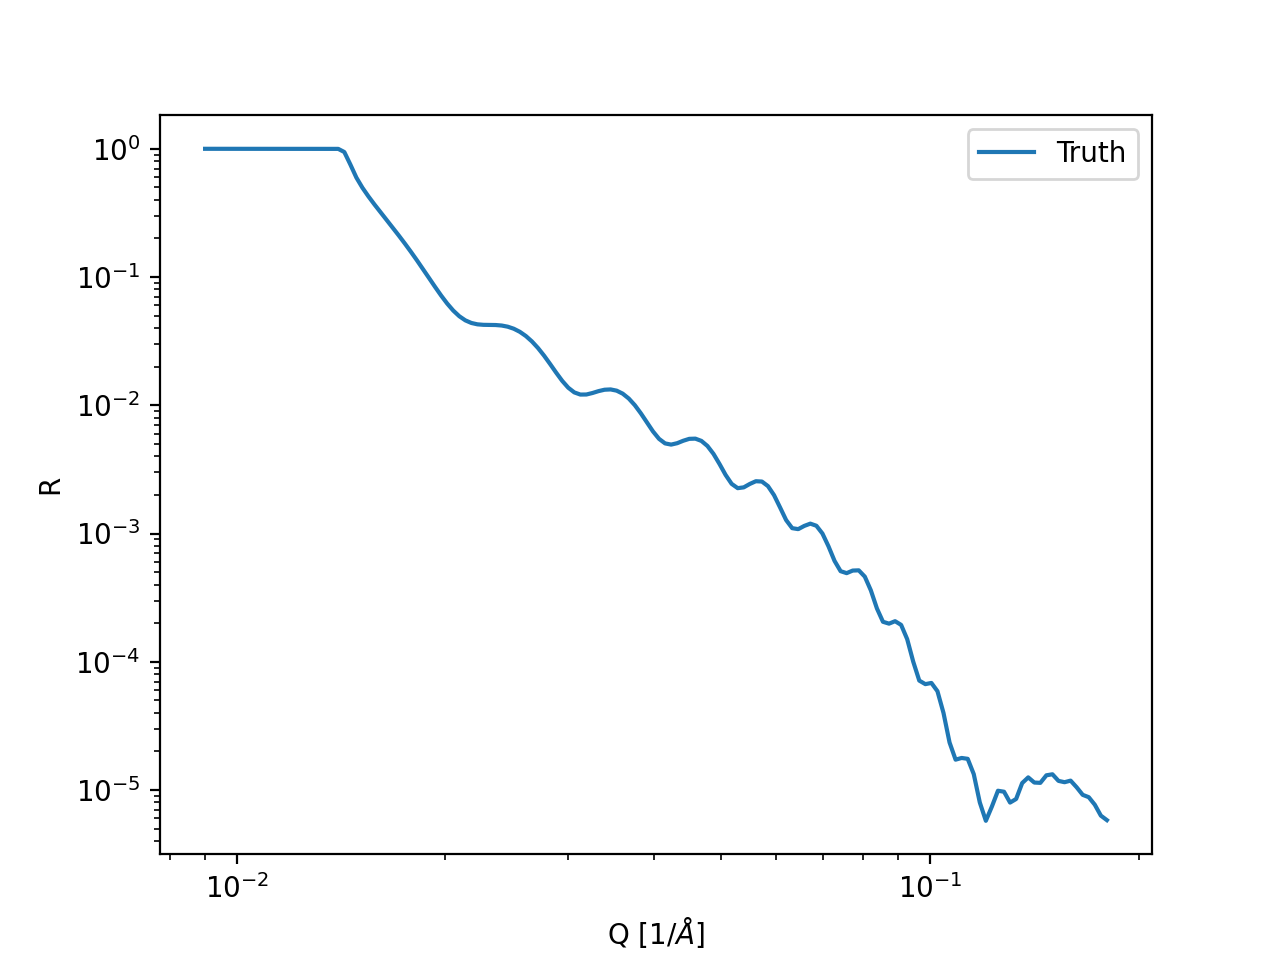

In [20]:
importlib.reload(rl_model)

# initialize the environment
env.reset()
env.render()

terminated = False
#while not terminated: 
for i in range(1):
    #time.sleep(1)

    # choose a random action
    action = env.action_space.sample()   

    # take the action and get the information from the environment
    new_state, reward, terminated, truncated, info = env.step(action)
  
    # show the current position and reward
    env.render(action=action, reward=reward) 
    env.plot()

In [4]:
import fitting.model_utils
importlib.reload(fitting.model_utils)

<module 'fitting.model_utils' from '/Users/m2d/git/Bayes-ML-sld/src/fitting/model_utils.py'>

In [31]:
q = np.logspace(np.log10(0.009), np.log10(0.2), num=150)
expt_file = '/Users/m2d/git/analysis_playground/stanford/dyn-fitting/188241-expt.json'

expt = fitting.model_utils.expt_from_json_file(expt_file, q)
_, r1 = expt.reflectivity()

print(expt.sample._layers[2].thickness.value)

expt.sample._layers[2].thickness.value = 400
expt.update()

print(expt.sample._layers[2].thickness.value)

_, r2 = expt.reflectivity()

print(expt.parameters())
#for i in range(len(q)):
#    print(r1[i], r2[i])



538.3
400
{'sample': {'thickness': Parameter(stack thickness), 'layers': [{'thickness': Parameter(dTHF thickness), 'interface': Parameter(dTHF interface), 'material': {'rho': Parameter(dTHF rho), 'irho': Parameter(dTHF irho)}}, {'thickness': Parameter(oxide thickness), 'interface': Parameter(oxide interface), 'material': {'rho': Parameter(oxide rho), 'irho': Parameter(oxide irho)}}, {'thickness': Parameter(Mo thickness), 'interface': Parameter(Mo interface), 'material': {'rho': Parameter(Mo rho), 'irho': Parameter(Mo irho)}}, {'thickness': Parameter(Si thickness), 'interface': Parameter(Si interface), 'material': {'rho': Parameter(Si rho), 'irho': Parameter(Si irho)}}]}, 'probe': {'intensity': Parameter(normalization), 'background': Parameter(background), 'back_absorption': Parameter(back_absorption), 'theta_offset': Parameter(theta_offset), 'sample_broadening': Parameter(sample_broadening)}}
